<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/scott_data606/OIGworkplan_Initial_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OIG Workplan & Reports EDA (Step 1)
An Exploratory Analysis of Current HHS OIG Workplan and Reports data.   
Notes on the scraping and methodology can be found in the project folder. 

## Objectives:
- Explore and Visualize the Initial Data for the *Workplan_df* and its connected *Reports_df*
- Create Word Clouds Based on some initial text cleaning

## EDA: Work Plan Data
- The OIG workplan is a tabular re-creation of all of the current (and former) ongoing HHS OIG work from FY2018 on. It includes both the work plans, and connected reports, defined as:

**OIG Work Plans**: Work Plans are general overviews of the scope of the project that OIG is looking to undertake.  
**OIG Reports**: Summaries of the work undertaken, as well as the findings and recommendations for that work product.

*Note:* OIG's work plans are connected to a report, however, there is ongoing work, so not every work plan will have an attached report. However, some work plans may have more than one connected report.

In [1]:
#For Cleaner Notebook Display
from IPython.display import clear_output

In [2]:
#Import Packages
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.tokenize import RegexpTokenizer
from nltk.stem import RegexpStemmer
from wordcloud import WordCloud, STOPWORDS

nltk.download(['punkt', 
               'stopwords'])

warnings.filterwarnings('ignore')
clear_output()

## a. Load DataFrames from Scraped Sources
- Workplan_df: The OIG Work Plan, a list and summaries of work that OIG is (or has) undertaken.
- Reports_df: All scraped, connected reports to any listed work plan items.

In [3]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_workplan_summaries.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

#Drop dead column
reports_df.drop(columns = 'Unnamed: 0',
                inplace = True)

## b. Initial Overview of Data
Analyze the Workplan Data

In [4]:
#Print Basic Stats for Both Dataframes:
print(f"{workplan_df.info()}{reports_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Announced or Revised      659 non-null    object
 1   Agency                    659 non-null    object
 2   Title                     659 non-null    object
 3   Component                 658 non-null    object
 4   Report Number(s)          659 non-null    object
 5   Expected Issue Date (FY)  656 non-null    object
 6   Website_Link              659 non-null    object
 7   Summary                   659 non-null    object
dtypes: object(8)
memory usage: 41.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Report Number(s)  737 non-null    object
 1   Workplan_Title    599 non-null    object
 2   Workplan_Summary  598 

## Work Plans:

In [5]:
#What are the statuses of all items?
workplan_df['Announced or Revised'].value_counts()[0:10]

Completed              266
Revised                115
Completed (partial)     70
Nov-16                  29
Removed                 28
November 2021           11
February 2022           10
June 2021                8
December 2021            7
January 2022             6
Name: Announced or Revised, dtype: int64

## Are products listed more than once?

In [6]:
#Multiple-Listed Audits/Evaluations
workplan_titles = workplan_df.Title.value_counts().reset_index()

workplan_titles.columns = ['Summary_Title', 
                           'Count']

workplan_titles[workplan_titles['Count'] > 1]

,Summary_Title,Count
0,Ensuring Dual-Eligible Beneficiaries' Access t...,5
1,Superfund Financial Activities at the National...,3
2,Mandatory Review of HHS Agencies' Annual Accou...,2
3,OIG Oversight of State Medicaid Fraud Control ...,2
4,Audit of the Department of Health and Human Se...,2
5,Comparison of Average Sales Prices and Average...,2
6,Audit of Administration for Community Living's...,2
7,State Medicaid Fraud Control Units FY 2017 Ann...,2
8,HHS Compliance with the Improper Payment Elimi...,2
9,Meeting the Challenges Presented by COVID-19: ...,2


Titles can remain the same, since some work products can be repeated year to year. However, let's check the unique identifiers to see if there are true duplicates in the dataset.

In [7]:
workplan_df["Report Number(s)"].value_counts()

W-00-22-59465                   2
W-00-22-59467                   2
W-00-21-59458                   2
OEI-09-18-00180                 2
A-04-20-02031;W-00-20-20021     2
                               ..
W-00-17-35801, W-00-21-35801    1
W-00-17-35803; A-05-xx-xxxxx    1
A-18-17-04002                   1
OEI-02-17-00490                 1
OEI-05-22-00330                 1
Name: Report Number(s), Length: 653, dtype: int64

It looks like there are a few duplicates. Let's remove these duplicates out, so that there aren't any potential issues.

In [8]:
workplan_df[workplan_df["Report Number(s)"].notna()]

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
0,Completed,Administration for Children and Families,States' Accuracy of Reporting TANF Spending In...,Office of Audit Services,A-02-17-02005; W-00-17-25100,2021,https://oig.hhs.gov/reports-and-publications/w...,The Temporary Assistance for Needy Families (T...
1,Completed,Administration for Children and Families,Head Start: Review of Single Audit Findings an...,Office of Audit Services,"A-02-16-02009, A-09-16-01004, A-06-17-07003;...",2018,https://oig.hhs.gov/reports-and-publications/w...,Effective for awards made on or after December...
2,Completed,Administration for Children and Families,Unaccompanied Children Program Grantee Reviews,Office of Audit Services,A-02-16-02013; A-04-16-03566; A-02-16-02007;...,2020,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
3,Nov-16,Administration for Children and Families,Recommendation Follow-Up: Office of Refugee Re...,Office of Evaluation and Inspections,OEI-09-16-00260,2017,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
4,October 2020,Administration for Children and Families,ACF Oversight of Guardian Ad Litem Requirement...,Office of Evaluation and Inspections,OEI-12-16-00120,2022,https://oig.hhs.gov/reports-and-publications/w...,As a condition of receiving Child Abuse Preven...
...,...,...,...,...,...,...,...,...
654,June 2022,Centers for Medicare and Medicaid Services,Medicare Administrative Contractor Cost Report...,Office of Audit Services,W-00-22-35886,2023,https://oig.hhs.gov/reports-and-publications/w...,HHS contracts with Medicare Administrative Con...
655,June 2022,Centers for Medicare and Medicaid Services,States' and MCOs' Compliance With Mental Healt...,Office of Audit Services,W-00-22-31565,2023,https://oig.hhs.gov/reports-and-publications/w...,The Paul Wellstone and Pete Domenici Mental He...
656,June 2022,Administration for Children and Families,Audit of the Low Income Home Energy Assistance...,Office of Audit Services,W-00-22-20036,2023,https://oig.hhs.gov/reports-and-publications/w...,The Low Income Home Energy Assistance Program ...
657,June 2022,Indian Health Service,Indian Health Service Capacity To Manage Suppl...,Office of Evaluation and Inspections,OEI-06-22-00320,2023,https://oig.hhs.gov/reports-and-publications/w...,The Indian Health Service (IHS) Sanitation Fac...


In [9]:
#Drop Duplicates for Summaries Data
mask = workplan_df["Report Number(s)"].notna()

workplan_df = workplan_df[mask].drop_duplicates()

workplan_df.shape

(659, 8)

### What Agencies are commonly the scope of OIG's reporting?

In [10]:
#Top-5 Agencies from Work Plans
pd.DataFrame(workplan_df['Agency'].value_counts())[0:10]

,Agency
Centers for Medicare & Medicaid Services,293
Centers for Medicare and Medicaid Services,122
Administration for Children and Families,46
National Institutes of Health,26
Food and Drug Administration,20
Centers for Disease Control and Prevention,18
Indian Health Service,15
Other,14
OS,14
Health Resources and Services Administration,13


### - What is the scope of the represented from work plan data?
- Office of Audit Services = Audits
- Office of Evaluation and Inspections = Evaluations

In [11]:
#Standardize Data
workplan_df['Component'] = ["Office of Evaluation and Inspections" 
                            if comp == "Office of Evaluation and Inspection" else comp
                            for comp in workplan_df['Component']]

#Show Top-5 Agencies from Work Plans
df_components = pd.DataFrame(workplan_df['Component'].value_counts())
df_components

,Component
Office of Audit Services,423
Office of Evaluation and Inspections,234
Office of Audit Services and Office of Evaluation and Inspections,1


## OIG Reports

In [12]:
reports_df.head()

,Report Number(s),Workplan_Title,Workplan_Summary
0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...
1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...
2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...
3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...
4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...


In [13]:
#Report Numbers are Unique Identifiers
reports_df['Report Number(s)'].value_counts()

A-05-17-00000      3
A-07-16-00486      3
A-04-20-02031      2
A-02-17-01026      2
A-07-21-00609      2
                  ..
OEI-03-16-00420    1
OEI-03-17-00410    1
OEI-03-16-00540    1
OEI-03-17-00360    1
OEI-05-22-00290    1
Name: Report Number(s), Length: 717, dtype: int64

Let's remove duplicates of any Report Number or Summary

In [14]:
#Drop Duplicates for Summaries Data
mask = reports_df['Workplan_Title'].notna() & reports_df['Workplan_Summary'].notna()

reports_df = reports_df[mask].drop_duplicates()

reports_df.shape

(584, 3)

In total, the OIG Work Plan has: 
- 659 Summaries, and 
- 584 connected reports

#Digging Deeper into the text data

In [15]:
#Determine Stopwords
stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (asp and amp were relics of links within the page)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',
                  'oig',
                  'hhs',
                  'amp',
                  'asp',
                  'href',
                  'determine',
                  'whether',
                  'will',
                  'review',
                  'asp',
                  'amp',
                  'oas',
                  'oei',
                  't t',
                  'n'])

In [16]:
################################
# Tokenize Work Plan Summaries #
################################

workplan_clean_df = workplan_df.copy()

#Set tokenizer as regex tokenizer to remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_clean_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_clean_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

#Set of unique tokens
workplan_clean_df["summary_unique_token"] = [len(set(sum_tok)) for sum_tok in workplan_clean_df["summary_tokenized"]]

In [17]:
#Is there any noticeable difference across the components for presented summary length?
workplan_clean_df[["Component", "summary_token_num","summary_unique_token"]].groupby('Component').agg(['sum', 'mean', 'min', 'max'])

summary_token_num  \
                                                                 sum   
Component                                                              
Office of Audit Services                                       37784   
Office of Audit Services and Office of Evaluati...                88   
Office of Evaluation and Inspections                           20166   

                                                                        \
                                                         mean min  max   
Component                                                                
Office of Audit Services                            89.323877  19  273   
Office of Audit Services and Office of Evaluati...  88.000000  88   88   
Office of Evaluation and Inspections                86.179487  31  230   

                                                   summary_unique_token  \
                                                                    sum   
Component                                                                 
Office of Audit Services                                          25077   
Office of Audit Services and Office of Evaluati...                   53   
Office of Evaluation and Inspections                              13688   

                                                                        
                                                         mean min  max  
Component                                                               
Office of Audit Services                            59.283688  16  147  
Office of Audit Services and Office of Evaluati...  53.000000  53   53  
Office of Evaluation and Inspections                58.495726  26  119

In [18]:
#Is there any noticeable difference across the components for Agency?
workplan_clean_df[["Agency", "summary_token_num","summary_unique_token"]].groupby('Agency').agg(['count', 'sum', 'mean', 'min', 'max'])

summary_token_num         \
                                                               count    sum   
Agency                                                                        
ACF                                                                3    274   
ACF, CDC, CMS, HRSA, IHS, NIH, SAMHSA                              1     79   
ASA                                                                1    110   
ASFR                                                               1     59   
ASPR, CDC, FDA, NIH, CMS                                           1     36   
Administration for Children and Families                          46   4673   
Administration for Children and Families, CDC, ...                 1     56   
Administration for Children and Families;  Cent...                 1     69   
Administration for Community Living                                6    615   
All STAFFDIV/OPDIVs                                                1     19   
Assistant Secretary for Preparedness and Response                  6    540   
CDC, ACF                                                           1    107   
CDC, NIH, AHRQ                                                     1     69   
CMS, AHRQ                                                          1     87   
CMS, AHRQ, OMHA                                                    1    124   
CMS, ASPR                                                          1     98   
CMS, FDA                                                           1     79   
Centers for Disease Control and Prevention                        18   2097   
Centers for Medicare & Medicaid Services                         293  23596   
Centers for Medicare and Medicaid Services                       122  11013   
FDA, NIH, CMS                                                      1     69   
Food & Drug Administration                                         1     74   
Food and Drug Administration                                      20   1883   
HHS                                                                4    324   
HHS, OCR, CMS                                                      1    184   
Health Resources & Services Administration                         2    230   
Health Resources and Services Administration                      13   1537   
IHS  NIH  HRSA  CDC                                                1     49   
Indian Health Service                                             15   1834   
Indian Health Services                                             5    439   
National Institutes of Health                                     26   2432   
OS                                                                14   1167   
OS, ACF, ACL, AHRQ, CDC, FDA, HRSA, NIH, SAMHSA                    1     48   
OS, ACF, CMS, CDC, FDA                                             1     94   
OS, CDC, ASPR                                                      1     88   
OS, HRSA, CDC                                                      1     48   
OS, OIG, CMS, FDA, CDC                                             1     81   
Office of Evaluation and Inspections                               1    103   
Office of Inspector General                                        1     48   
Office of the Assistant Secretary for Administr...                 3    208   
Office of the Assistant Secretary for Financial...                 1     86   
Office of the Assistant Secretary for Preparedn...                 2    282   
Office of the Secretary                                            5    372   
Other                                                             14   1155   
Other Public Health Reviews                                        4    270   
Substance Abuse and Mental Health Services Admi...                13   1250   

                                                                          \
                                                          mean  min  max   
Agency                     

## Visualizations

<Figure size 1080x576 with 0 Axes>

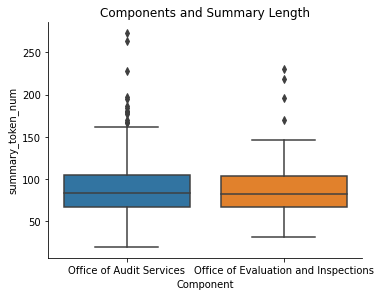

In [19]:
mask = [True if comp in ["Office of Audit Services", "Office of Evaluation and Inspections"] 
        else False for comp in workplan_clean_df["Component"]]

plt.figure(figsize = (15,8))

sns.catplot(x="Component", 
            y="summary_token_num", 
            kind="box", 
            data=workplan_clean_df[mask],
            height = 4,
            aspect = 12/9).set(title ="Components and Summary Length")

In [20]:
#How many unique tokens do we have from our list of work plan summaries?
len(set(workplan_clean_df["summary_tokenized"].apply(pd.Series).stack().unique()))

4331

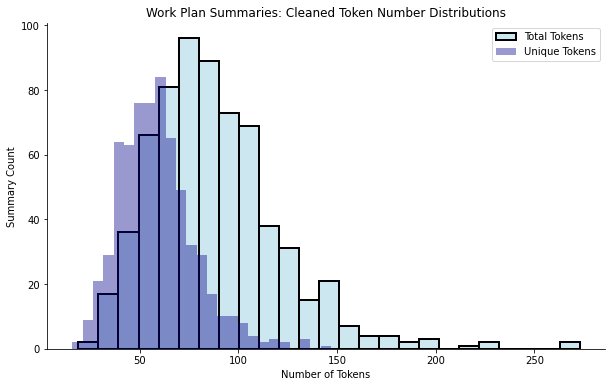

In [21]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), sharex = True, sharey = True)

sns.histplot(data=workplan_clean_df, 
             x="summary_token_num", 
             bins = 25,
             color = 'lightblue',
             alpha = .6,
             label = 'Total Tokens',
             linewidth = 2)

sns.histplot(data=workplan_clean_df, 
             x="summary_unique_token", 
             bins = 25,
             color = 'darkblue',
             alpha = .40,
             label = 'Unique Tokens',
             linewidth = 0)

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Summary Count")
ax.legend()

### Work Plan: Word Cloud of Frequent Words
- What words are we seeing occur the most frequently?

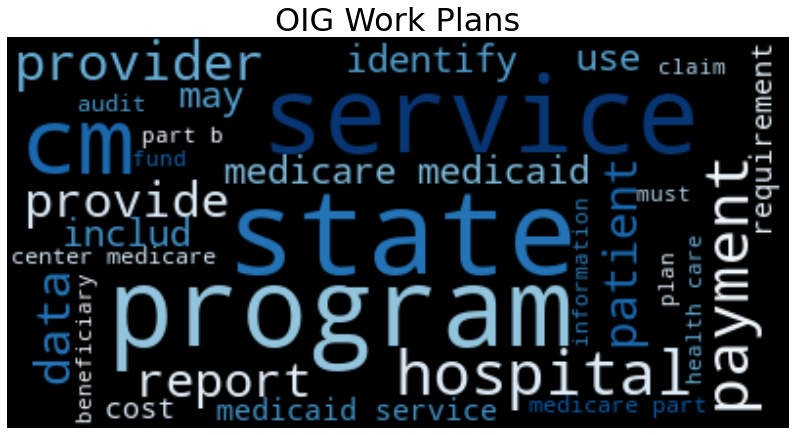

In [22]:
#########################
# Workplan: Word Cloud  #
#########################

#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (14,10))

# Start with one review:
text = str([' '.join(word) for word in workplan_clean_df["summary_tokenized"]])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=60, 
                      max_words=30,
                      background_color = 'black',
                      colormap = 'Blues').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("OIG Work Plans", size = 32)
plt.show()

## OIG Reports
- Reports are summaries of the specific findings and recommendations that OIG discovers after the work on a specific project has been completed. They include details on the project scope, as well as recommendations found from the project itself. 

In [23]:
reports_df.head()

,Report Number(s),Workplan_Title,Workplan_Summary
0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...
1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...
2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...
3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...
4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...


In [24]:
reports_df['Workplan_Summary'] = reports_df['Workplan_Summary'].fillna(' ')

In [25]:
reports_df['Workplan_Summary'] 

0      The Temporary Assistance for Needy Families (T...
1      The Administration for Children and Families (...
2      Head Start grantees are required to have Singl...
3      Head Start grantees are required to have Singl...
4      The Office of Refugee Resettlement (ORR) withi...
                             ...                        
713    When Congress established average sales price ...
715    Background checks for employees of long-term-c...
720    For the fiscal year (FY) 2021 coordinated over...
724    This report provides the results of our review...
725    This report provides the results of our review...
Name: Workplan_Summary, Length: 584, dtype: object

In [26]:
#Subset out any workplan product with no title
reports_clean_df = reports_df[reports_df['Workplan_Title'].notna()]

In [27]:
################################
# Tokenize Work Plan Reports   #
################################
#Set tokenizer as regex tokenizer to remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in reports_clean_df["Workplan_Summary"]]

tokenized_sums = [[i for i in tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
reports_clean_df["summary_tokenized"] = tokenized_stemmed_sums

#Number of tokens after cleaning data
reports_clean_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

#Set of unique tokens
reports_clean_df["summary_unique_token"] = [len(set(sum_tok)) for sum_tok in reports_clean_df["summary_tokenized"]]

In [28]:
#Show Cleaned Dataframe
reports_clean_df.head()

,Report Number(s),Workplan_Title,Workplan_Summary,summary_tokenized,summary_token_num,summary_unique_token
0,A-02-17-02005,New York Did Not Have Adequate Oversight of It...,The Temporary Assistance for Needy Families (T...,"[temporary, assistance, needy, famil, tanf, pr...",357,159
1,A-02-16-02009,The Administration for Children and Families R...,The Administration for Children and Families (...,"[administration, children, famil, acf, proces,...",202,108
2,A-09-16-01004,The Administration for Children and Families R...,Head Start grantees are required to have Singl...,"[head, start, grantee, required, single, audit...",137,87
3,A-06-17-07003,The Administration for Children and Families D...,Head Start grantees are required to have Singl...,"[head, start, grantee, required, single, audit...",249,127
4,A-02-16-02013,"The Children's Village, Inc., an Administratio...",The Office of Refugee Resettlement (ORR) withi...,"[office, refugee, resettlement, orr, within, d...",342,186


In [29]:
#How many unique tokens do we have from the reports data?
#https://stackoverflow.com/questions/38895856/how-to-compile-all-lists-in-a-column-into-one-unique-list
print("Total Tokens:")
len(set(reports_clean_df["summary_tokenized"].apply(pd.Series).stack().unique()))

Total Tokens:


5775

In [30]:
def word_stats(df):
    try:
        total_tokens = df["summary_token_num"].sum()
        
    except Exception as e:
        print(e)

    try:
        unique_tokens = (len(set(df["summary_tokenized"].apply(pd.Series).stack().unique())))

    except Exception as e:
        print(e)

    return [total_tokens, unique_tokens]

### OIG Reports: Word Cloud of Frequent Words
- What words are we seeing occur the most frequently?

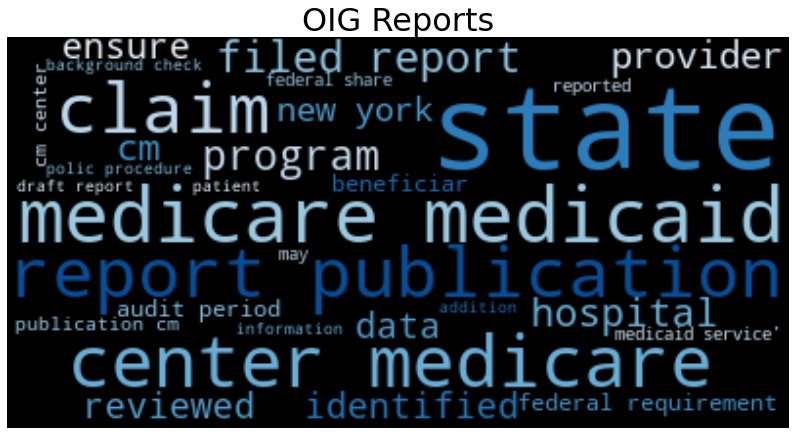

In [31]:
#########################
# Reports: Word Cloud   #
#########################
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (14,10))

# Start with one review:
text = str([' '.join(word) for word in reports_clean_df["summary_tokenized"]])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=60,
                      max_words=30,
                      background_color = 'black',
                      colormap = 'Blues_r').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("OIG Reports", size = 32)
plt.show()

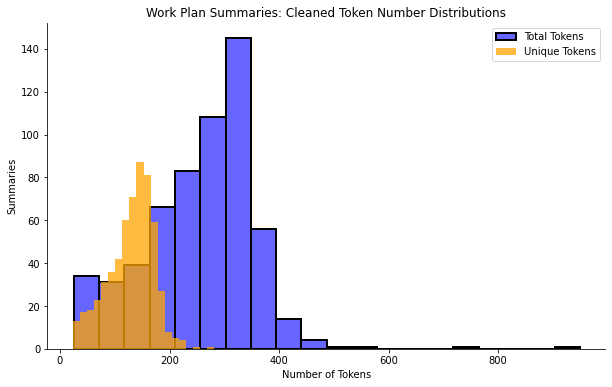

In [32]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), 
                       sharex = True, 
                       sharey = True)

sns.histplot(data=reports_clean_df, 
             x="summary_token_num", 
             bins = 20,
             color = 'blue',
             alpha = .6,
             label = 'Total Tokens',
             linewidth = 2)

sns.histplot(data=reports_clean_df, 
             x="summary_unique_token", 
             bins = 20,
             color = 'orange',
             alpha = .75,
             label = 'Unique Tokens',
             linewidth = 0)

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Summaries")
ax.legend()

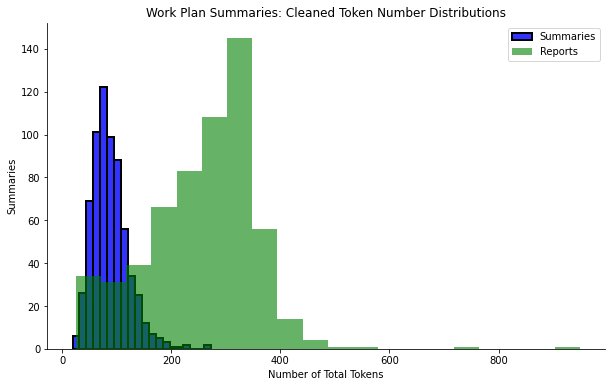

In [33]:
#Visualize the number of tokens for summaries and reports
fig, ax = plt.subplots(figsize= (10,6), sharex = True)

#Comparing the number of tokens 
sns.histplot(data=workplan_clean_df, 
             x="summary_token_num", 
             bins = 20,
             color = 'blue',
             alpha = .8,
             label = 'Summaries',
             linewidth = 2,
             ax = ax)

sns.histplot(data=reports_clean_df, 
             x="summary_token_num", 
             bins = 20,
             ax = ax,
             color = 'green',
             alpha = .6,
             linewidth = 0,
             label = 'Reports')

#Style Plot
sns.despine()
ax.set_title("Work Plan Summaries: Cleaned Token Number Distributions")
ax.set_xlabel("Number of Total Tokens")
ax.set_ylabel("Summaries")
ax.legend()

Let's move on to the next step...